<a href="https://colab.research.google.com/github/Chia-Tien-Tang/Deep-Learning-in-Practice_Assignment/blob/main/TP3_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Session on Graph Neural Networks

**by Matthieu Nastorg and Cyriaque Rousselot**

## **PART 1 : CODING** (8/20)

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [ ]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/
#####################################################
import torch


def format_pytorch_version(version):
    return version.split("+")[0]


TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)


def format_cuda_version(version):
    return "cu" + version.replace(".", "")


CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 96.8 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 28.9 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 51.8 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.2 MB/s eta 0:00:00


### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it :

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

In [ ]:
#####################################################
################## PACKAGES #########################
#####################################################
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node:
- 50 features : positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct node's labels**.

**It is a node (multi-level) classification task** (trained using supervised learning).

For your curiosity, more details information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


In [ ]:
### LOAD DATASETS

BATCH_SIZE = 2

# Train Dataset
train_dataset = PPI(root="", split="train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split="val")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split="test")
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

Extracting ./ppi.zip
Processing...


Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])
Number of features per node:  50
Number of classes per node:  121


Done!


### Define a basic Model

Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-level) classification task, computing 121 features.

In [ ]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):
        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)

        return x

Next we construct the function to train the model.

In [ ]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(
    model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader
):

    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

Next function is designed to evaluate the performance of the model, computing the F1-Score

In [ ]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):
    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Let's train this model !

In [ ]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

### DEFINE THE MODEL
basic_model = BasicGraphModel(
    input_size=n_features, hidden_size=256, output_size=n_classes
).to(device)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train(
    basic_model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_dataloader,
    val_dataloader,
)


Device:  cuda
Epoch 00001 | Loss: 0.6383
F1-Score: 0.4426
Epoch 00002 | Loss: 0.5801
Epoch 00003 | Loss: 0.5613
Epoch 00004 | Loss: 0.5543
Epoch 00005 | Loss: 0.5501
Epoch 00006 | Loss: 0.5461
F1-Score: 0.5084
Epoch 00007 | Loss: 0.5419
Epoch 00008 | Loss: 0.5374
Epoch 00009 | Loss: 0.5340
Epoch 00010 | Loss: 0.5311
Epoch 00011 | Loss: 0.5285
F1-Score: 0.5263
Epoch 00012 | Loss: 0.5261
Epoch 00013 | Loss: 0.5236
Epoch 00014 | Loss: 0.5211
Epoch 00015 | Loss: 0.5188
Epoch 00016 | Loss: 0.5165
F1-Score: 0.5281
Epoch 00017 | Loss: 0.5144
Epoch 00018 | Loss: 0.5122
Epoch 00019 | Loss: 0.5100
Epoch 00020 | Loss: 0.5079
Epoch 00021 | Loss: 0.5058
F1-Score: 0.5185
Epoch 00022 | Loss: 0.5036
Epoch 00023 | Loss: 0.5013
Epoch 00024 | Loss: 0.4993
Epoch 00025 | Loss: 0.4972
Epoch 00026 | Loss: 0.4954
F1-Score: 0.5338
Epoch 00027 | Loss: 0.4936
Epoch 00028 | Loss: 0.4917
Epoch 00029 | Loss: 0.4901
Epoch 00030 | Loss: 0.4883
Epoch 00031 | Loss: 0.4867
F1-Score: 0.5456
Epoch 00032 | Loss: 0.4849
Ep

Let's evaluate the performance of this basic model

Basic Model : F1-Score on the test set: 0.6378


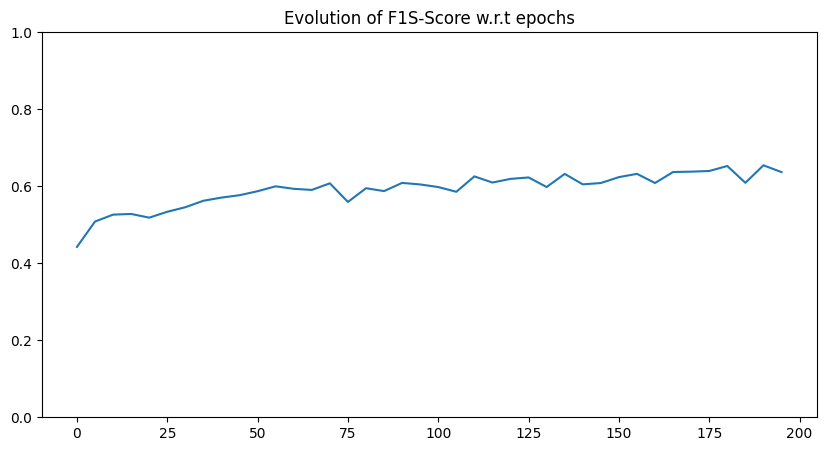

In [ ]:
### F1-SCORE ON TEST DATASET
score_test = evaluate(basic_model, loss_fcn, device, test_dataloader)
print("Basic Model : F1-Score on the test set: {:.4f}".format(score_test))


### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1S-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()


plot_f1_score(epoch_list, basic_model_scores)

### Define a better model

Now, it's your turn to improve this basic model ! To do so, complete whenever ###### YOUR ANSWER ######## and run the two following cells.

**HINT :** https://arxiv.org/pdf/1710.10903.pdf

#GAT Transductive Learning Model (Without using Sigmoid)

In [ ]:
from torch_geometric.nn import GATConv

In [ ]:
class StudentModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
      super().__init__()

      ####### YOUR ANSWER #######
       # GAT layers
      self.gatconv1 = graphnn.GATConv(input_size, hidden_size, heads=8, dropout=0.6)
      self.gatconv2 = graphnn.GATConv(8*hidden_size, hidden_size, heads=8, concat=False, dropout=0.6)
      
      # Linear layer for multi-label classification
      self.linear = nn.Linear(hidden_size, output_size)

      # Activation
      self.elu = nn.ELU()

  def forward(self, x, edge_index):

      ####### YOUR ANSWER #######
      x = self.gatconv1(x, edge_index)
      x = self.elu(x)
      x = self.gatconv2(x, edge_index)
      x = self.elu(x)
      x = self.linear(x)
      return x

Let's train your model !

In [ ]:
## Student model
# student_model = StudentModel(##### YOUR ANSWER #####).to(device)
student_model = StudentModel(input_size=n_features, hidden_size=256, output_size=n_classes).to(device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005)

### TRAIN
epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 0.5976
F1-Score: 0.4003
Epoch 00002 | Loss: 0.5414
Epoch 00003 | Loss: 0.5271
Epoch 00004 | Loss: 0.5185
Epoch 00005 | Loss: 0.5116
Epoch 00006 | Loss: 0.5074
F1-Score: 0.4808
Epoch 00007 | Loss: 0.5059
Epoch 00008 | Loss: 0.5001
Epoch 00009 | Loss: 0.4962
Epoch 00010 | Loss: 0.4942
Epoch 00011 | Loss: 0.4916
F1-Score: 0.5461
Epoch 00012 | Loss: 0.4887
Epoch 00013 | Loss: 0.4850
Epoch 00014 | Loss: 0.4812
Epoch 00015 | Loss: 0.4799
Epoch 00016 | Loss: 0.4772
F1-Score: 0.5943
Epoch 00017 | Loss: 0.4746
Epoch 00018 | Loss: 0.4744
Epoch 00019 | Loss: 0.4731
Epoch 00020 | Loss: 0.4707
Epoch 00021 | Loss: 0.4679
F1-Score: 0.6129
Epoch 00022 | Loss: 0.4645
Epoch 00023 | Loss: 0.4643
Epoch 00024 | Loss: 0.4601
Epoch 00025 | Loss: 0.4560
Epoch 00026 | Loss: 0.4567
F1-Score: 0.6128
Epoch 00027 | Loss: 0.4539
Epoch 00028 | Loss: 0.4546
Epoch 00029 | Loss: 0.4546
Epoch 00030 | Loss: 0.4514
Epoch 00031 | Loss: 0.4484
F1-Score: 0.5982
Epoch 00032 | Loss: 0.4446
Epoch 00033 | Los

Let's evaluate the performance of your model

Student Model : F1-Score on the test set: 0.7303


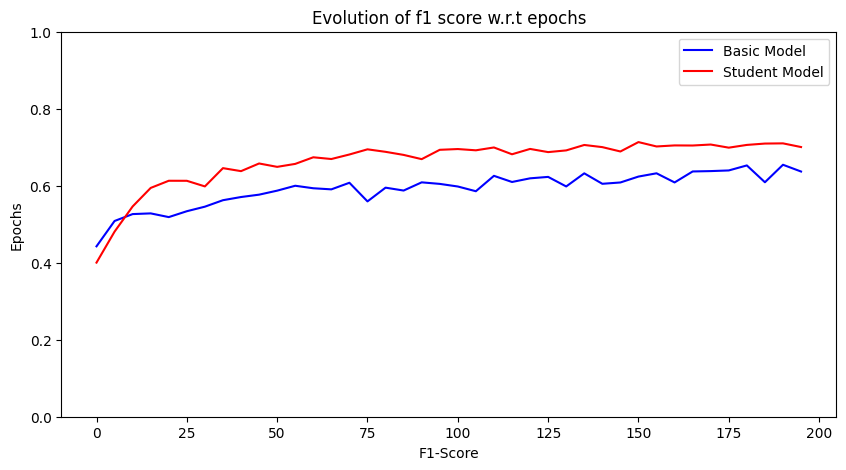

In [ ]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))


def plot_f1_score(epoch_list, basic_model_scores, student_model_scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, basic_model_scores, "b", label="Basic Model")
    plt.plot(epoch_list, student_model_scores, "r", label="Student Model")
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.ylabel("Epochs")
    plt.xlabel("F1-Score")
    plt.legend()
    plt.show()


plot_f1_score(epoch_list, basic_model_scores, student_model_scores)

#GAT Inductive Learning Model (With Normal Xavier initialization & Without using Sigmoid)

In [ ]:
class StudentModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self._init_weights()

        # GAT layers
        self.gat1 = GATConv(input_size, hidden_size, heads=6, concat=True)
        self.gat2 = GATConv(hidden_size * 6, hidden_size, heads=6, concat=True)
        self.gat3 = GATConv(hidden_size * 6, output_size, heads=4, concat=False)

        # Activation
        self.elu = nn.ELU()

    def _init_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x, edge_index):
        # First GAT layer
        x = self.elu(self.gat1(x, edge_index))
        x_skip = x.clone()
        # Second GAT layer
        x = self.elu(self.gat2(x, edge_index))
        # Third GAT layer for classification
        x = x + x_skip
        x = self.gat3(x, edge_index)
        return x

In [ ]:
## Student model
# student_model = StudentModel(##### YOUR ANSWER #####).to(device)
student_model = StudentModel(input_size=n_features, hidden_size=256, output_size=n_classes).to(device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005)

### TRAIN
epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 0.7773
F1-Score: 0.4564
Epoch 00002 | Loss: 0.5619
Epoch 00003 | Loss: 0.5394
Epoch 00004 | Loss: 0.5278
Epoch 00005 | Loss: 0.5166
Epoch 00006 | Loss: 0.5048
F1-Score: 0.4786
Epoch 00007 | Loss: 0.4985
Epoch 00008 | Loss: 0.4928
Epoch 00009 | Loss: 0.4864
Epoch 00010 | Loss: 0.4802
Epoch 00011 | Loss: 0.4792
F1-Score: 0.5381
Epoch 00012 | Loss: 0.4708
Epoch 00013 | Loss: 0.4640
Epoch 00014 | Loss: 0.4570
Epoch 00015 | Loss: 0.4513
Epoch 00016 | Loss: 0.4542
F1-Score: 0.5079
Epoch 00017 | Loss: 0.4604
Epoch 00018 | Loss: 0.4509
Epoch 00019 | Loss: 0.4374
Epoch 00020 | Loss: 0.4261
Epoch 00021 | Loss: 0.4206
F1-Score: 0.6184
Epoch 00022 | Loss: 0.4187
Epoch 00023 | Loss: 0.4271
Epoch 00024 | Loss: 0.4248
Epoch 00025 | Loss: 0.4077
Epoch 00026 | Loss: 0.3985
F1-Score: 0.6468
Epoch 00027 | Loss: 0.3936
Epoch 00028 | Loss: 0.3935
Epoch 00029 | Loss: 0.3911
Epoch 00030 | Loss: 0.3849
Epoch 00031 | Loss: 0.3733
F1-Score: 0.6822
Epoch 00032 | Loss: 0.3663
Epoch 00033 | Los

Student Model : F1-Score on the test set: 0.9382


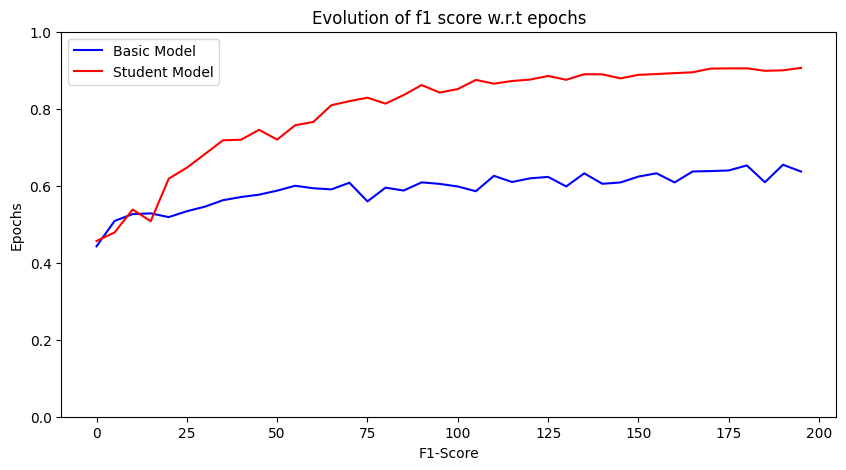

In [ ]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))


def plot_f1_score(epoch_list, basic_model_scores, student_model_scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, basic_model_scores, "b", label="Basic Model")
    plt.plot(epoch_list, student_model_scores, "r", label="Student Model")
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.ylabel("Epochs")
    plt.xlabel("F1-Score")
    plt.legend()
    plt.show()


plot_f1_score(epoch_list, basic_model_scores, student_model_scores)

**With Epoch 300**

In [ ]:
## Student model
# student_model = StudentModel(##### YOUR ANSWER #####).to(device)
student_model = StudentModel(input_size=n_features, hidden_size=256, output_size=n_classes).to(device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005)

### TRAIN
epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, 300, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 0.7263
F1-Score: 0.4538
Epoch 00002 | Loss: 0.5569
Epoch 00003 | Loss: 0.5526
Epoch 00004 | Loss: 0.5298
Epoch 00005 | Loss: 0.5181
Epoch 00006 | Loss: 0.5071
F1-Score: 0.5267
Epoch 00007 | Loss: 0.5006
Epoch 00008 | Loss: 0.4931
Epoch 00009 | Loss: 0.4855
Epoch 00010 | Loss: 0.4797
Epoch 00011 | Loss: 0.4855
F1-Score: 0.5233
Epoch 00012 | Loss: 0.4790
Epoch 00013 | Loss: 0.4694
Epoch 00014 | Loss: 0.4613
Epoch 00015 | Loss: 0.4559
Epoch 00016 | Loss: 0.4462
F1-Score: 0.6152
Epoch 00017 | Loss: 0.4351
Epoch 00018 | Loss: 0.4233
Epoch 00019 | Loss: 0.4182
Epoch 00020 | Loss: 0.4139
Epoch 00021 | Loss: 0.4086
F1-Score: 0.6436
Epoch 00022 | Loss: 0.4029
Epoch 00023 | Loss: 0.3960
Epoch 00024 | Loss: 0.4010
Epoch 00025 | Loss: 0.3894
Epoch 00026 | Loss: 0.3803
F1-Score: 0.6814
Epoch 00027 | Loss: 0.3755
Epoch 00028 | Loss: 0.3683
Epoch 00029 | Loss: 0.3584
Epoch 00030 | Loss: 0.3530
Epoch 00031 | Loss: 0.3497
F1-Score: 0.7153
Epoch 00032 | Loss: 0.3549
Epoch 00033 | Los

In [ ]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))

Student Model : F1-Score on the test set: 0.9557


## **PART 2 : QUESTIONS** (12/20)

**1. Make a small paragraph that : (4pts)**
1. Explains your achitecture and justify your choices (why the Graph Layer you chose is more efficient than the GCNLayer from the Basic Model?).
2. Analyses your results (what is the F1-Score ? are your results convincing ? what is your position w.r.t state-of-the-art ?).

>Answer  

1.  
According to our observation and study of paper, we think that the main difference between GCN and GATs is how the node features are aggregated. Actually, in GCN layers, they apply the same weight to all neighbors of a node, however, GAT layers use self-attention mechanisms to weigh the different importance of each neighbor's features so that GATs model can be able to focus on more relevant features to learn more complex patterns from the data.

Architecture from paper starts with a GAT layer, which allows to expand the feature representation with using multi-head attention. Through this layer, the model can increase the its capacity by learning from different representation subspaces. The following GAT layers clarify these features. At the end, the final layer collapses the multi-head outputs to match the number of output features size.

**[Key Factors]**  
    - **Skip Connections**: Form of residual learning. It can help resolve the vanishing gradient problems and then make network more effectively by allowing gradients to flow, especially for deeper architectures (Like what we did from 200 epochs to 300 epochs).  
    - **Initializtion of weights**: We use Xavier initialization to prevent initial weights to be neither too small nor too large. And if we initial it correctly then we can guarantee that the model can learn more effectively and also have stable learning process and faster convergence.  

Conclusion: PPI network dataset has relationships between proteins that can have various degrees of relevance. GATs model is more efficient than GCN because of its ability to capture the varying significance of different nodes within the graph more accurately.

2.  
The F1-Score for our GAT Inductive model on the PPI dataset is 0.9557 after 300 epochs (In the state-of-the-art, it uses only 200 epochs and achieves 0.973 ± 0.002). Although we have around 0.015 diffrence compared to the state-of-art, we still think that we already achieve a pretty good score on this compleicated task, "node classification in PPI networks". And also comopared to all the other listed state-of-art models, including GraphSAGE variants, our GAT model outperforms well. So in conclusion, we believe that our model is not only accurate but also generalizes well on the test data, It shows the effectiveness of the graph attention mechanisms in handling the intricate structures of biological data.

**2. Provide a diagramm of your architecture, which includes a good and clear legend as well as shapes information. The diagramm must be submitted as an external file, along with this notebook (PDF, JEPG or PNG format accepted). (2pts)**

**3. Make a small paragraph that explains: (6pts)**
1. What _oversmoothing_ is in the context of Graph Neural Network. Why is it an issue ?
2. Are there solutions to overcome it ?
3. Do you think the model you constructed is robust with respect to oversmoothing ? Why ?

While leveraging the message passing mechanism enables us to utilize the information embedded within the graph structure, it can pose limitations when combined with deep GNNs. Essentially, our pursuit of a highly expressive model that is cognizant of the graph structure, achieved by adding more layers to increase the receptive field of nodes, may inadvertently lead to all nodes being treated equally. This convergence of node representations towards indistinguishable vectors undermines the model's ability to capture and differentiate between diverse node characteristics.

There are some solutions to overcome oversmoothing:


1. Skip Connections: Incorporating skip connections, akin to those used in Residual Networks (ResNets) for image classification, can facilitate the flow of information across different layers, preventing the loss of crucial node-specific features during deep propagation.

2. Graph Attention Mechanisms: Implementing attention mechanisms tailored to graph structures allows the model to selectively focus on relevant nodes during message passing, thereby preserving the diversity of node representations even in deep architectures.

3. Graph Pooling Operations: Employing graph pooling operations such as GraphSAGE or Graph Isomorphism Networks (GINs) can aid in aggregating information from different parts of the graph while maintaining the uniqueness of node representations.

4. Regularization Techniques: Introducing regularization techniques such as dropout or graph Laplacian regularization helps prevent overfitting and encourages the model to learn more robust and informative node representations.

5. Hierarchical Architectures: Designing hierarchical GNN architectures that capture information at multiple scales of granularity enables the model to maintain a balance between local and global graph structure awareness, thereby mitigating the risk of representation collapse.